   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.8 MB/s eta 0:00:00
Dataset loaded successfully:
   Temp (°C)  Wind (Bft)  Atm (inHg)  Rate (inHg/3h)  Flood Intensity (mm/h)  \
0      25.49        7.85       28.86            0.63                    78.1   
1      29.13       12.49       28.25            0.85                    84.7   
2      13.08        1.49       31.25            0.02                    13.9   
3      19.64        4.80       29.65            0.10                    35.2   
4      34.30        9.34       28.46            0.72                    81.0   

  Flood Risk Category  Risk_Num  
0                High         3  
1           Very High         4  
2            Very Low         0  
3                 Low         1  
4           Very High         4  

Dataset shape: (94, 4)


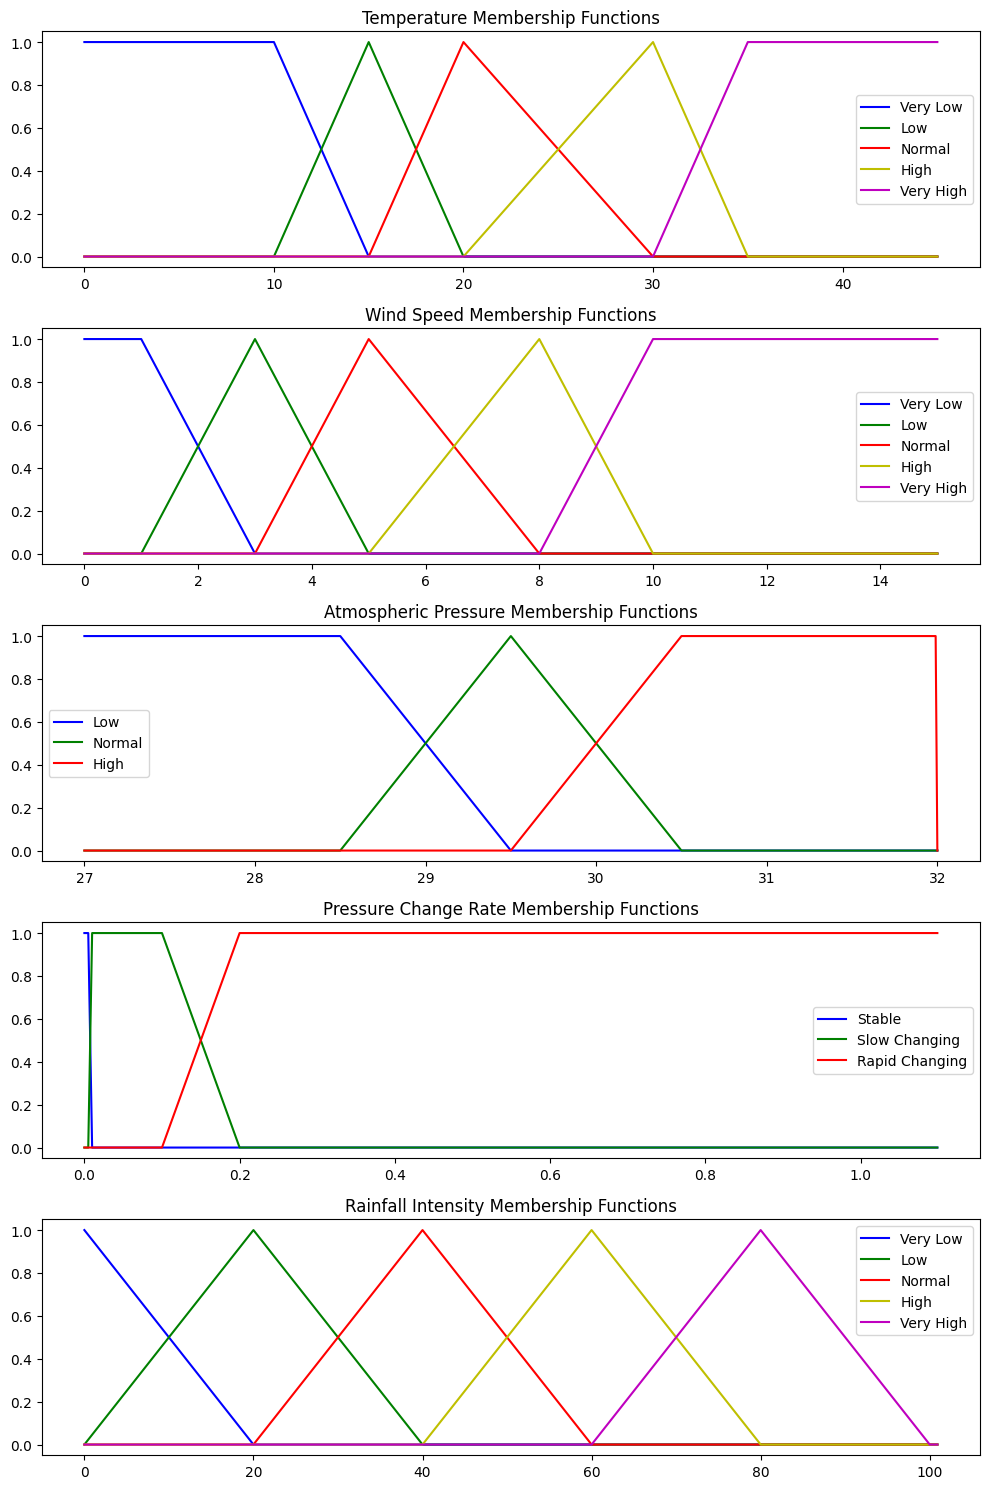


Training neural network...
Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 2794.8806 - mae: 47.3346 - val_loss: 1601.7767 - val_mae: 33.6530
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2503.6440 - mae: 44.7324 - val_loss: 1400.9088 - val_mae: 30.6166
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2093.8650 - mae: 39.6495 - val_loss: 1210.6256 - val_mae: 27.6426
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 1950.8490 - mae: 38.0131 - val_loss: 1031.0339 - val_mae: 24.5559
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1728.7891 - mae: 35.4415 - val_loss: 854.8674 - val_mae: 21.4981
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1524.2184 - mae: 33.1616 - val_loss: 693.0486 - val_mae: 18.5373
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1167.7448 - mae: 28.4777 - val_loss: 547.0778 - val_mae: 16.2030
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 926.1716 - mae: 25.7253 - val_loss: 427.8467 - val_mae: 14.4177
Epoch 9/300
2/2 ━━━━━━━

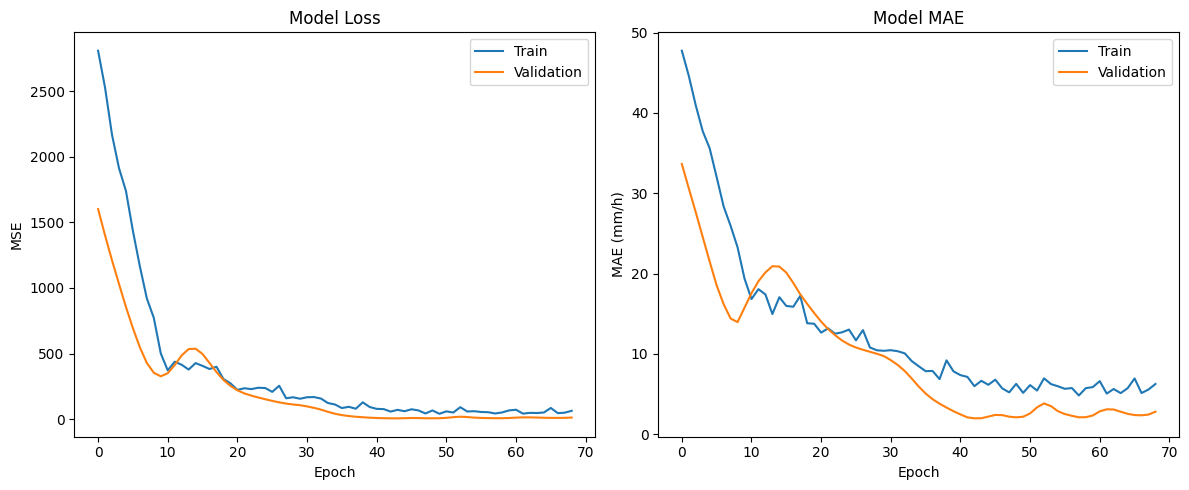


Evaluating models...

Performance Metrics:
Model           MSE        MAE       
Neural Network  39.0156 3.4013
Fuzzy System    43.8371 4.8700
Hybrid System   35.1495 3.7336


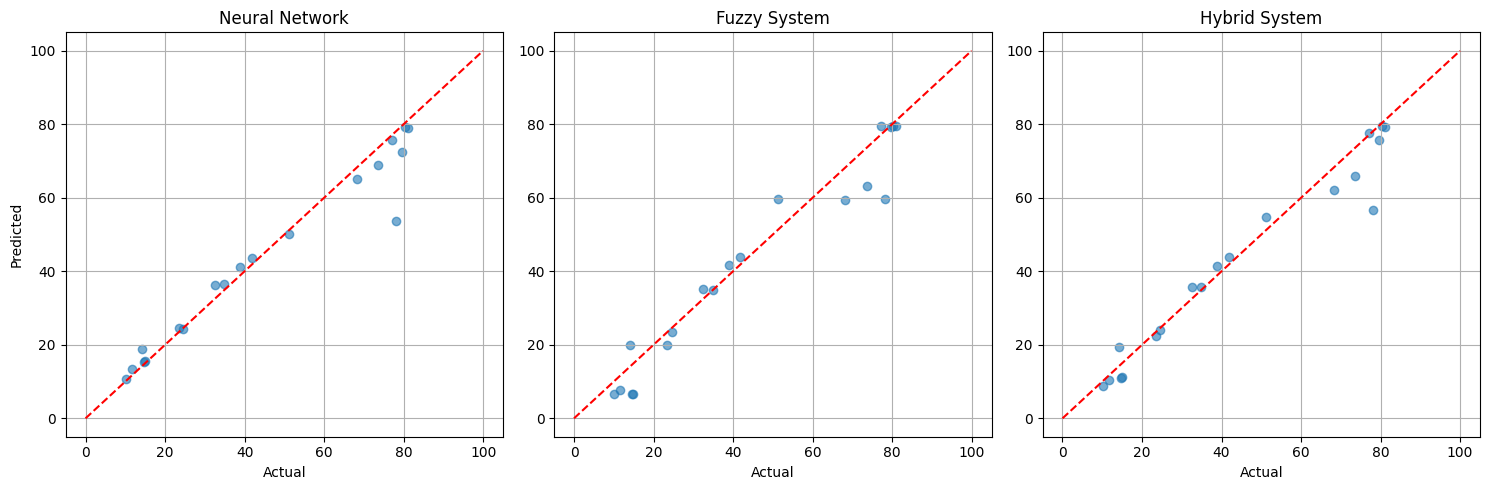


Example Predictions:

Input: Temp=32.4°C, Wind=10.2 Bft, Atm=28.40 inHg, Rate=0.620 inHg/3h
- Actual: 77.20 mm/h
- Neural Net: 75.71 mm/h
- Fuzzy System: 79.51 mm/h
- Hybrid: 77.61 mm/h

Input: Temp=21.1°C, Wind=4.6 Bft, Atm=29.87 inHg, Rate=0.090 inHg/3h
- Actual: 32.50 mm/h
- Neural Net: 36.23 mm/h
- Fuzzy System: 35.13 mm/h
- Hybrid: 35.68 mm/h

Input: Temp=17.7°C, Wind=3.3 Bft, Atm=30.51 inHg, Rate=0.050 inHg/3h
- Actual: 23.40 mm/h
- Neural Net: 24.67 mm/h
- Fuzzy System: 20.00 mm/h
- Hybrid: 22.34 mm/h

Input: Temp=10.6°C, Wind=1.0 Bft, Atm=31.40 inHg, Rate=0.000 inHg/3h
- Actual: 10.10 mm/h
- Neural Net: 10.73 mm/h
- Fuzzy System: 6.74 mm/h
- Hybrid: 8.73 mm/h

Input: Temp=15.7°C, Wind=2.1 Bft, Atm=30.97 inHg, Rate=0.010 inHg/3h
- Actual: 14.10 mm/h
- Neural Net: 18.92 mm/h
- Fuzzy System: 20.00 mm/h
- Hybrid: 19.46 mm/h


In [1]:
!pip install scikit-fuzzy tensorflow matplotlib numpy scikit-learn openpyxl pandas
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# =====================================
# 1. DATA LOADING AND PREPROCESSING
# =====================================
def load_dataset(file_path):
    """Load and preprocess the dataset from Excel"""
    df = pd.read_excel(file_path)

    # Convert flood risk categories to numerical values
    risk_mapping = {
        'Very Low': 0,
        'Low': 1,
        'Normal': 2,
        'High': 3,
        'Very High': 4
    }
    df['Risk_Num'] = df['Flood Risk Category'].map(risk_mapping)

    # Extract inputs and outputs
    X = df[['Temp (°C)', 'Wind (Bft)', 'Atm (inHg)', 'Rate (inHg/3h)']].values
    y = df['Flood Intensity (mm/h)'].values

    return X, y, df

# =====================================
# 2. FUZZY LOGIC SYSTEM SETUP
# =====================================
# Define universe variables
temp = np.arange(0, 45.01, 0.1)    # Temperature (°C)
wind = np.arange(0, 15.01, 0.1)    # Wind speed (Bft)
atm = np.arange(27, 32.01, 0.01)   # Atmospheric pressure (inHg)
rate = np.arange(0, 1.1, 0.001)    # Pressure change rate (inHg/3h)
rain = np.arange(0, 101, 0.1)      # Rainfall intensity (mm/h)

# Temperature membership functions
temp_vl = fuzz.trapmf(temp, [0, 0, 10, 15])  # Very Low
temp_l = fuzz.trimf(temp, [10, 15, 20])      # Low
temp_n = fuzz.trimf(temp, [15, 20, 30])      # Normal
temp_h = fuzz.trimf(temp, [20, 30, 35])      # High
temp_vh = fuzz.trapmf(temp, [30, 35, 45, 45]) # Very High

# Wind speed membership functions
wind_vl = fuzz.trapmf(wind, [0, 0, 1, 3])    # Very Low
wind_l = fuzz.trimf(wind, [1, 3, 5])         # Low
wind_n = fuzz.trimf(wind, [3, 5, 8])         # Normal
wind_h = fuzz.trimf(wind, [5, 8, 10])        # High
wind_vh = fuzz.trapmf(wind, [8, 10, 15, 15]) # Very High

# Atmospheric pressure membership functions
atm_l = fuzz.trapmf(atm, [27, 27, 28.5, 29.5]) # Low
atm_n = fuzz.trimf(atm, [28.5, 29.5, 30.5])    # Normal
atm_h = fuzz.trapmf(atm, [29.5, 30.5, 32, 32]) # High

# Pressure change rate membership functions
rate_s = fuzz.trapmf(rate, [0, 0, 0.005, 0.01])    # Stable
rate_sc = fuzz.trapmf(rate, [0.005, 0.01, 0.1, 0.2]) # Slowly Changing
rate_rc = fuzz.trapmf(rate, [0.1, 0.2, 1.1, 1.1])   # Rapidly Changing

# Rainfall output membership functions
rain_vl = fuzz.trimf(rain, [0, 0, 20])      # Very Low
rain_l = fuzz.trimf(rain, [0, 20, 40])      # Low
rain_n = fuzz.trimf(rain, [20, 40, 60])     # Normal
rain_h = fuzz.trimf(rain, [40, 60, 80])     # High
rain_vh = fuzz.trimf(rain, [60, 80, 100])   # Very High

def plot_membership_functions():
    """Visualize all membership functions"""
    fig, axes = plt.subplots(5, 1, figsize=(10, 15))

    # Temperature
    axes[0].plot(temp, temp_vl, 'b', label='Very Low')
    axes[0].plot(temp, temp_l, 'g', label='Low')
    axes[0].plot(temp, temp_n, 'r', label='Normal')
    axes[0].plot(temp, temp_h, 'y', label='High')
    axes[0].plot(temp, temp_vh, 'm', label='Very High')
    axes[0].set_title('Temperature Membership Functions')
    axes[0].legend()

    # Wind Speed
    axes[1].plot(wind, wind_vl, 'b', label='Very Low')
    axes[1].plot(wind, wind_l, 'g', label='Low')
    axes[1].plot(wind, wind_n, 'r', label='Normal')
    axes[1].plot(wind, wind_h, 'y', label='High')
    axes[1].plot(wind, wind_vh, 'm', label='Very High')
    axes[1].set_title('Wind Speed Membership Functions')
    axes[1].legend()

    # Atmospheric Pressure
    axes[2].plot(atm, atm_l, 'b', label='Low')
    axes[2].plot(atm, atm_n, 'g', label='Normal')
    axes[2].plot(atm, atm_h, 'r', label='High')
    axes[2].set_title('Atmospheric Pressure Membership Functions')
    axes[2].legend()

    # Pressure Change Rate
    axes[3].plot(rate, rate_s, 'b', label='Stable')
    axes[3].plot(rate, rate_sc, 'g', label='Slow Changing')
    axes[3].plot(rate, rate_rc, 'r', label='Rapid Changing')
    axes[3].set_title('Pressure Change Rate Membership Functions')
    axes[3].legend()

    # Rainfall Intensity
    axes[4].plot(rain, rain_vl, 'b', label='Very Low')
    axes[4].plot(rain, rain_l, 'g', label='Low')
    axes[4].plot(rain, rain_n, 'r', label='Normal')
    axes[4].plot(rain, rain_h, 'y', label='High')
    axes[4].plot(rain, rain_vh, 'm', label='Very High')
    axes[4].set_title('Rainfall Intensity Membership Functions')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

def validate_inputs(input_temp, input_wind, input_atm, input_rate):
    """Ensure inputs are within dataset ranges"""
    input_temp = np.clip(input_temp, 5, 40)
    input_wind = np.clip(input_wind, 0.5, 14)
    input_atm = np.clip(input_atm, 28, 31.5)
    input_rate = np.clip(input_rate, 0.001, 1.0)
    return input_temp, input_wind, input_atm, input_rate

def fuzzification(input_temp, input_wind, input_atm, input_rate):
    """Convert crisp inputs to fuzzy values"""
    input_temp, input_wind, input_atm, input_rate = validate_inputs(
        input_temp, input_wind, input_atm, input_rate)

    # Temperature membership
    temp_is_vl = fuzz.interp_membership(temp, temp_vl, input_temp)
    temp_is_l = fuzz.interp_membership(temp, temp_l, input_temp)
    temp_is_n = fuzz.interp_membership(temp, temp_n, input_temp)
    temp_is_h = fuzz.interp_membership(temp, temp_h, input_temp)
    temp_is_vh = fuzz.interp_membership(temp, temp_vh, input_temp)

    # Wind speed membership
    wind_is_vl = fuzz.interp_membership(wind, wind_vl, input_wind)
    wind_is_l = fuzz.interp_membership(wind, wind_l, input_wind)
    wind_is_n = fuzz.interp_membership(wind, wind_n, input_wind)
    wind_is_h = fuzz.interp_membership(wind, wind_h, input_wind)
    wind_is_vh = fuzz.interp_membership(wind, wind_vh, input_wind)

    # Atmospheric pressure membership
    atm_is_l = fuzz.interp_membership(atm, atm_l, input_atm)
    atm_is_n = fuzz.interp_membership(atm, atm_n, input_atm)
    atm_is_h = fuzz.interp_membership(atm, atm_h, input_atm)

    # Pressure change rate membership
    rate_is_s = fuzz.interp_membership(rate, rate_s, input_rate)
    rate_is_sc = fuzz.interp_membership(rate, rate_sc, input_rate)
    rate_is_rc = fuzz.interp_membership(rate, rate_rc, input_rate)

    return (
        [temp_is_vl, temp_is_l, temp_is_n, temp_is_h, temp_is_vh],
        [wind_is_vl, wind_is_l, wind_is_n, wind_is_h, wind_is_vh],
        [atm_is_l, atm_is_n, atm_is_h],
        [rate_is_s, rate_is_sc, rate_is_rc]
    )

def inference_engine(temp_arr, wind_arr, atm_arr, rate_arr):
    """Apply fuzzy rules to determine rainfall intensity"""
    temp_is_vl, temp_is_l, temp_is_n, temp_is_h, temp_is_vh = temp_arr
    wind_is_vl, wind_is_l, wind_is_n, wind_is_h, wind_is_vh = wind_arr
    atm_is_l, atm_is_n, atm_is_h = atm_arr
    rate_is_s, rate_is_sc, rate_is_rc = rate_arr

    # Rule 1: Very Low Rainfall conditions
    rule1 = np.fmin(
        np.fmin(
            np.fmax(temp_is_vl, temp_is_l),
            np.fmax(wind_is_vl, wind_is_l)
        ),
        np.fmin(rate_is_s, atm_is_h)
    )
    r1_out = np.fmin(rule1, rain_vl)

    # Rule 2: Low Rainfall conditions
    rule2 = np.fmin(
        np.fmax(
            np.fmin(temp_is_vl, np.fmax(wind_is_n, wind_is_h)),
            np.fmax(
                np.fmin(temp_is_l, wind_is_n),
                np.fmax(
                    np.fmin(temp_is_n, np.fmax(wind_is_vl, wind_is_l)),
                    np.fmin(temp_is_h, wind_is_vl)
                )
            )
        ),
        np.fmax(
            np.fmin(rate_is_s, atm_is_n),
            np.fmin(rate_is_sc, atm_is_h)
        )
    )
    r2_out = np.fmin(rule2, rain_l)

    # Rule 3: Normal Rainfall conditions
    rule3 = np.fmin(
        np.fmax(
            np.fmin(temp_is_vh, wind_is_vl),
            np.fmax(
                np.fmin(np.fmax(temp_is_h, temp_is_vh), wind_is_l),
                np.fmax(
                    np.fmin(np.fmax(temp_is_n, temp_is_h), wind_is_n),
                    np.fmax(
                        np.fmin(np.fmax(temp_is_l, temp_is_n), wind_is_h),
                        np.fmin(np.fmax(temp_is_vl, temp_is_l), wind_is_vh)
                    )
                )
            )
        ),
        np.fmax(
            np.fmin(rate_is_s, atm_is_l),
            np.fmax(
                np.fmin(rate_is_sc, atm_is_n),
                np.fmin(rate_is_rc, atm_is_h)
            )
        )
    )
    r3_out = np.fmin(rule3, rain_n)

    # Rule 4: High Rainfall conditions
    rule4 = np.fmin(
        np.fmax(
            np.fmin(temp_is_vh, wind_is_n),
            np.fmax(
                np.fmin(np.fmax(temp_is_h, temp_is_vh), wind_is_h),
                np.fmin(np.fmax(temp_is_n, temp_is_h), wind_is_vh)
            )
        ),
        np.fmax(
            np.fmin(rate_is_sc, atm_is_l),
            np.fmin(rate_is_rc, atm_is_n)
        )
    )
    r4_out = np.fmin(rule4, rain_h)

    # Rule 5: Very High Rainfall conditions
    rule5 = np.fmin(
        np.fmin(temp_is_vh, wind_is_vh),
        np.fmin(rate_is_rc, atm_is_l)
    )
    r5_out = np.fmin(rule5, rain_vh)

    # Aggregate all outputs
    aggregated = np.fmax(r1_out, r2_out)
    aggregated = np.fmax(aggregated, r3_out)
    aggregated = np.fmax(aggregated, r4_out)
    aggregated = np.fmax(aggregated, r5_out)

    # Ensure minimum activation
    min_activation = 0.01 * rain_vl
    aggregated = np.fmax(aggregated, min_activation)

    return aggregated

def defuzzification(fuzz_out):
    """Convert fuzzy output to crisp value"""
    try:
        if np.sum(fuzz_out) == 0 or np.max(fuzz_out) < 0.01:
            return 50.0  # Return midpoint if no rules fired
        return fuzz.defuzz(rain, fuzz_out, "centroid")
    except Exception as e:
        print(f"Defuzzification warning: {str(e)} - Using fallback value")
        return 50.0

# =====================================
# 3. NEURAL NETWORK IMPLEMENTATION
# =====================================
class FloodPredictionModel:
    def __init__(self, input_shape):
        """Enhanced neural network for flood prediction"""
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=300, batch_size=32):
        """Train with early stopping and validation"""
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=25, restore_best_weights=True)

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
        return history

    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0).flatten()

# =====================================
# 4. HYBRID SYSTEM IMPLEMENTATION
# =====================================
class HybridFloodPredictor:
    def __init__(self, fuzzy_system, nn_model):
        self.fuzzy_system = fuzzy_system
        self.nn_model = nn_model

    def predict(self, X):
        """Combine fuzzy and neural network predictions"""
        fuzzy_preds = []
        for x in X:
            # Fuzzy prediction
            temp_arr, wind_arr, atm_arr, rate_arr = fuzzification(x[0], x[1], x[2], x[3])
            fuzz_out = inference_engine(temp_arr, wind_arr, atm_arr, rate_arr)
            fuzzy_preds.append(defuzzification(fuzz_out))

        # Neural network prediction
        nn_preds = self.nn_model.predict(X)

        # Hybrid prediction (weighted average)
        return 0.5 * np.array(fuzzy_preds) + 0.5 * nn_preds

# =====================================
# 5. MAIN EXECUTION AND EVALUATION
# =====================================
def main():
    # 1. Load dataset
    try:
        X, y, df = load_dataset('/content/data.xlsx')
        print("Dataset loaded successfully:")
        print(df.head())
        print(f"\nDataset shape: {X.shape}")
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return

    # 2. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)

    # 3. Visualize membership functions
    plot_membership_functions()

    # 4. Train neural network
    print("\nTraining neural network...")
    nn_model = FloodPredictionModel(input_shape=(X_train.shape[1],))
    history = nn_model.train(X_train, y_train, X_val, y_val, epochs=300)

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train')
    plt.plot(history.history['val_mae'], label='Validation')
    plt.title('Model MAE')
    plt.ylabel('MAE (mm/h)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Initialize hybrid system
    hybrid_model = HybridFloodPredictor(None, nn_model)

    # 6. Evaluate all systems
    print("\nEvaluating models...")

    # Neural Network evaluation
    nn_pred = nn_model.predict(X_test)
    nn_mse = mean_squared_error(y_test, nn_pred)
    nn_mae = mean_absolute_error(y_test, nn_pred)

    # Fuzzy System evaluation
    fuzzy_pred = []
    for x in X_test:
        temp_arr, wind_arr, atm_arr, rate_arr = fuzzification(x[0], x[1], x[2], x[3])
        fuzz_out = inference_engine(temp_arr, wind_arr, atm_arr, rate_arr)
        fuzzy_pred.append(defuzzification(fuzz_out))
    fuzzy_mse = mean_squared_error(y_test, fuzzy_pred)
    fuzzy_mae = mean_absolute_error(y_test, fuzzy_pred)

    # Hybrid System evaluation
    hybrid_pred = hybrid_model.predict(X_test)
    hybrid_mse = mean_squared_error(y_test, hybrid_pred)
    hybrid_mae = mean_absolute_error(y_test, hybrid_pred)

    # Print results
    print("\nPerformance Metrics:")
    print(f"{'Model':<15} {'MSE':<10} {'MAE':<10}")
    print(f"{'Neural Network':<15} {nn_mse:.4f} {nn_mae:.4f}")
    print(f"{'Fuzzy System':<15} {fuzzy_mse:.4f} {fuzzy_mae:.4f}")
    print(f"{'Hybrid System':<15} {hybrid_mse:.4f} {hybrid_mae:.4f}")

    # 7. Visual comparison
    plt.figure(figsize=(15, 5))

    # Neural Network predictions
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, nn_pred, alpha=0.6)
    plt.plot([0, 100], [0, 100], 'r--')
    plt.title('Neural Network')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)

    # Fuzzy System predictions
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, fuzzy_pred, alpha=0.6)
    plt.plot([0, 100], [0, 100], 'r--')
    plt.title('Fuzzy System')
    plt.xlabel('Actual')
    plt.grid(True)

    # Hybrid System predictions
    plt.subplot(1, 3, 3)
    plt.scatter(y_test, hybrid_pred, alpha=0.6)
    plt.plot([0, 100], [0, 100], 'r--')
    plt.title('Hybrid System')
    plt.xlabel('Actual')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 8. Example predictions
    print("\nExample Predictions:")
    sample_indices = np.random.choice(len(X_test), 5, replace=False)
    for idx in sample_indices:
        actual = y_test[idx]
        inputs = X_test[idx]

        # Neural network prediction
        nn_pred = nn_model.predict(inputs.reshape(1, -1))[0]

        # Fuzzy prediction
        temp_arr, wind_arr, atm_arr, rate_arr = fuzzification(*inputs)
        fuzz_out = inference_engine(temp_arr, wind_arr, atm_arr, rate_arr)
        fuzzy_pred = defuzzification(fuzz_out)

        # Hybrid prediction
        hybrid_pred = hybrid_model.predict(inputs.reshape(1, -1))[0]

        print(f"\nInput: Temp={inputs[0]:.1f}°C, Wind={inputs[1]:.1f} Bft, "
              f"Atm={inputs[2]:.2f} inHg, Rate={inputs[3]:.3f} inHg/3h")
        print(f"- Actual: {actual:.2f} mm/h")
        print(f"- Neural Net: {nn_pred:.2f} mm/h")
        print(f"- Fuzzy System: {fuzzy_pred:.2f} mm/h")
        print(f"- Hybrid: {hybrid_pred:.2f} mm/h")

if __name__ == "__main__":
    main()